## Laboratorio 6 - Avances

### 1) Descargar los archivos de datos (traficogt.txt)

Para el laboratorio se decidió utilizar el archivo de tráficogt.txt ya que el tema parece bastante interesante y tiene mucho potencial para ser analizado.

Importaciones

In [35]:
import pandas as pd
import json
import re
import string
import unidecode
import nltk
from nltk.corpus import stopwords
import networkx as nx
import chardet
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### 2) Cargar los archivos a Python

In [ ]:
# Encontrar la codificación del archivo
with open("traficogt.txt", "rb") as f:
    rawdata = f.read(100000)  # leer un bloque
    print(chardet.detect(rawdata))

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


Vemos que la codificación detectada es UTF-16 y lo aplicamos para poder cargar el archivo a python.

In [ ]:
# Cargar tweets desde archivo JSONL (cada línea es un JSON)
tweets = []
with open("traficogt.txt", "r", encoding="utf-16") as f:
    for line_num, line in enumerate(f):
        try:
            tweets.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipping line {line_num + 1} due to JSONDecodeError: {e}")
        except Exception as e:
            print(f"Skipping line {line_num + 1} due to unexpected error: {e}")


df = pd.json_normalize(tweets)  # Convertir a DataFrame
display(df.head(3))

Skipping line 5605 due to JSONDecodeError: Expecting ',' delimiter: line 1 column 4314 (char 4313)


,id,id_str,url,date,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,...,quotedTweet.quotedTweet.inReplyToTweetIdStr,quotedTweet.quotedTweet.inReplyToUser,quotedTweet.quotedTweet.source,quotedTweet.quotedTweet.sourceUrl,quotedTweet.quotedTweet.sourceLabel,quotedTweet.quotedTweet.media.photos,quotedTweet.quotedTweet.media.videos,quotedTweet.quotedTweet.media.animated,quotedTweet.quotedTweet.card,quotedTweet.quotedTweet._type
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,es,Es comprensible la resolución... El ruso sabe ...,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1834039491826180424,1834039491826180424,https://x.com/animaldgalaccia/status/183403949...,2024-09-12 01:21:04+00:00,qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se omitió la línea 5605 porque el tweet estaba dañado o no cumplia con el formato, entonces se descartó. Esto es normal y no afecta el análisis.

Se cargaron 5604 tweets

Al expandir el JSON se obtuvo un dataframe con 210 columnas, que incluyen metadatos como id, date, user.username, rawContent, etc. Estos son los datos a los que se les realizará la limpieza.

### 3.1) Limpieza y preprocesamiento de los datos

In [ ]:
nltk.download("stopwords")
spanish_stopwords = set(stopwords.words("spanish"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[0-9]+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = "".join(c for c in text if c.isalnum() or c.isspace())
    text = unidecode.unidecode(text)
    tokens = [t for t in text.split() if t not in spanish_stopwords]
    return " ".join(tokens)

df["clean_text"] = df["rawContent"].astype(str).apply(clean_text)
df[["rawContent","clean_text"]].head(5)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,rawContent,clean_text
0,Es comprensible la resolución... El ruso sabe ...,comprensible resolucion ruso sabe engrasar maq...
1,La corrupción de la @CC_Guatemala\nes descarad...,corrupcion descarada falsificacion documentos ...
2,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,
3,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,
4,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,urgente zona deterioro tala inmoderada trafico...


### 3.2) Extracción de metadatos para identificar las relaciones entre usuarios

In [ ]:
edges = []

for _, row in df.iterrows():
    user = row["user.username"]

    # Menciones
    if isinstance(row.get("mentionedUsers"), list):
        for mention in row["mentionedUsers"]:
            edges.append((user, mention["username"], "mention"))

    # Retweets
    if row.get("retweetedTweet") is not None and isinstance(row["retweetedTweet"], dict):
        rt_user = row["retweetedTweet"]["user"]["username"]
        edges.append((user, rt_user, "retweet"))

    # Respuestas
    if row.get("inReplyToUser") is not None and isinstance(row["inReplyToUser"], dict):
        reply_user = row["inReplyToUser"]["username"]
        edges.append((user, reply_user, "reply"))

edges_df = pd.DataFrame(edges, columns=["source", "target", "type"])
display(edges_df.head(10))

,source,target,type
0,monymmorales,CC_Guatemala,mention
1,animaldgalaccia,PNCdeGuatemala,mention
2,animaldgalaccia,mingobguate,mention
3,animaldgalaccia,FJimenezmingob,mention
4,animaldgalaccia,diegoedeleon,mention
5,animaldgalaccia,amilcarmontejo,mention
6,animaldgalaccia,traficogt,mention
7,EstacionDobleA,amilcarmontejo,mention
8,EstacionDobleA,AztecaNoticiaGT,mention
9,EstacionDobleA,BancadaSemilla,mention


Aquí se ve una tabla donde source hace referencia al usuario que emitió el tweet. target contiene el usuario al que va dirigida la interacción y type es el tipo de interacción que puede ser mention, retweet o reply.

### 3.3) Eliminación de duplicados y normalización de nombres de usuario y menciones

In [ ]:
edges_df.drop_duplicates(inplace=True)
edges_df["source"] = edges_df["source"].str.lower()
edges_df["target"] = edges_df["target"].str.lower()

### 3.4) Creación de estructura de datos

In [ ]:
G = nx.from_pandas_edgelist(
    edges_df, source="source", target="target", edge_attr="type", create_using=nx.DiGraph()
)

print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())

edges_df.to_csv("red_interacciones.csv", index=False)

Nodos: 2720
Aristas: 7336


El grafo de interacciones creado contiene los nodos representan los 2720 usuarios únicos que aparecen en las conversaciones, mientras que las aristas son 7336 relaciones (menciones, retweets, respuestas).

Con este grafo ya se puede realizar el análisis de redes sociales.



### 4) Análisis exploratorio

In [ ]:
# Número de tweets cargados
total_tweets = len(df)

# Usuarios únicos
usuarios_unicos = df["user.username"].nunique()

# Número de menciones totales
total_menciones = edges_df[edges_df["type"] == "mention"].shape[0]

# Número de retweets
total_retweets = edges_df[edges_df["type"] == "retweet"].shape[0]

# Número de respuestas
total_respuestas = edges_df[edges_df["type"] == "reply"].shape[0]

print("Tweets totales:", total_tweets)
print("Usuarios únicos:", usuarios_unicos)
print("Menciones:", total_menciones)
print("Retweets:", total_retweets)
print("Respuestas:", total_respuestas)


Tweets totales: 5604
Usuarios únicos: 2071
Menciones: 7336
Retweets: 0
Respuestas: 0


In [ ]:
# Hashtags más frecuentes
def extraer_hashtags(texto):
    return re.findall(r"#\w+", str(texto).lower())

hashtags = df["rawContent"].apply(extraer_hashtags)
hashtags = [tag for sublist in hashtags for tag in sublist]

top_hashtags = Counter(hashtags).most_common(10)
print(top_hashtags)

[('#ahora', 30), ('#guatemala', 25), ('#ahoralh', 19), ('#urgente', 16), ('#traficogt', 16), ('#renunciengolpistas', 15), ('#paronacionalindefinido', 9), ('#lahoradeactualizarnos', 8), ('#guateresiste', 8), ('#paronacionaindefinido', 8)]


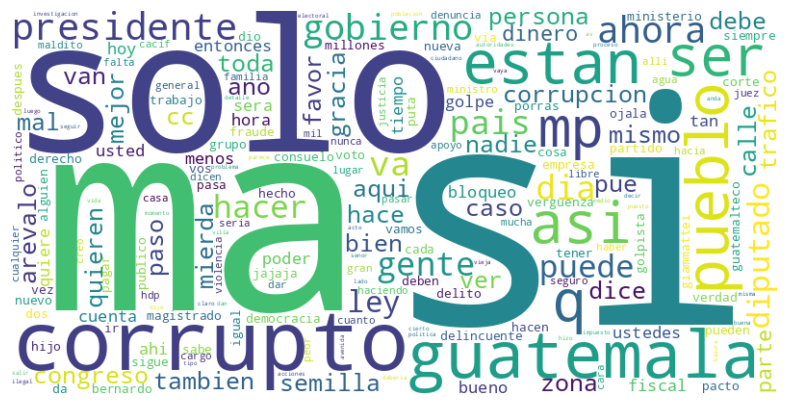

In [ ]:
# Nube de palabras de tweets limpios
text = " ".join(df["clean_text"].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white", collocations=False).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Usuarios más mencionados y más activos

# Más mencionados
top_mencionados = edges_df[edges_df["type"]=="mention"]["target"].value_counts().head(10)

# Más activos (quienes más interactúan)
top_activos = edges_df["source"].value_counts().head(10)

print("Usuarios más mencionados:\n", top_mencionados)
print("\nUsuarios más activos:\n", top_activos)

Usuarios más mencionados:
 target
traficogt          1891
barevalodeleon      327
drgiammattei        132
prensacomunitar     120
mmendoza_gt         109
mpguatemala         101
lahoragt             90
amilcarmontejo       90
cc_guatemala         79
muniguate            65
Name: count, dtype: int64

Usuarios más activos:
 source
mildred_gaitan     111
batallonjalapa     109
chofito63569841     58
traficogt           45
cubreserva          44
giovanottigt        41
erwin15             37
mariacdeleon1       33
erosan3edsa         32
hellboy17oc         32
Name: count, dtype: int64


### Insights preliminares

Se puede observar que las menciones predominan sobre retweets y respuestas lo que indica que las conversaciones giran más en torno a involucrar a otros usuarios que en la difusión pasiva de la información.

También que se que las cuentas oficiales y medios son los más mencionados como ejemplo, @traficogt, @PNCdeGuatemala, @amilcarmontejo, lo que sugiere que los usuarios los perciben como autoridad o responsables de dar soluciones.

Los hashtags suelen estar relacionados con protestas, corrupción política, urgencias o accidentes.

Se ve que hay cuentas pequeñas muy participativas que generan interacciones, mientras que otras con más visibilidad son constantemente citadas.

### 4.2) Preguntas interesantes sobre los datos

¿Quiénes son los usuarios más influyentes en la red?
Los más mencionados son @traficogt y @PNCdeGuatemala, concentran la atención de la comunidad, son nodos clave en la red de interacciones.

¿Qué temas generan mayor interacción?
Hashtags como #urgente, #desaparecido o menciones a instituciones públicas reflejan que la comunidad utiliza Twitter como canal de denuncia ciudadana y emergencia vial.

¿Predominan más las quejas o noticias?
El análisis de la nube de palabras muestra predominio de términos asociados a problemas como accidentes, corrupción, tráfico y desapariciones, más que mensajes neutrales o positivos.

### 5) Análisis de la topología de la red

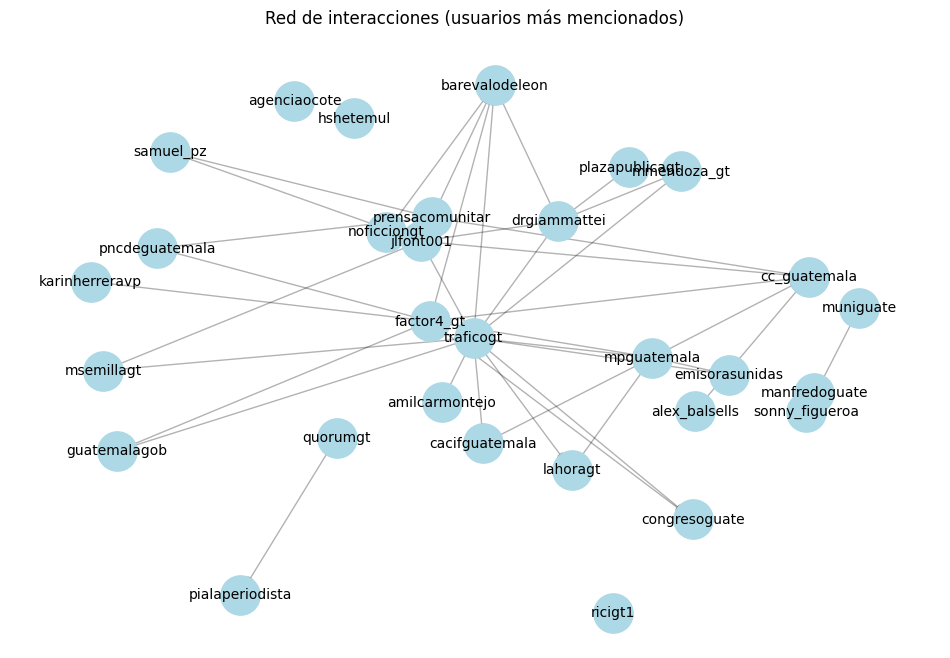

In [ ]:
# 5.1) Construcción y visualización de grafos

# Grafo reducido (para visualizar, usamos solo los más activos y mencionados)
top_nodes = edges_df["target"].value_counts().head(30).index.tolist()
subG = G.subgraph(top_nodes)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(subG, k=0.5, seed=42)

# Dibujar nodos
nx.draw_networkx_nodes(subG, pos, node_size=800, node_color="lightblue")

# Dibujar aristas
nx.draw_networkx_edges(subG, pos, alpha=0.3, arrows=True)

# Etiquetas de los nodos
nx.draw_networkx_labels(subG, pos, font_size=10)

plt.title("Red de interacciones (usuarios más mencionados)")
plt.axis("off")
plt.show()

Con este grafo se confirma que entre los usuarios más influyentes el principal es @traficogt que se encuentra en el centro y se puede observar que es el que tiene más conexiones con otros nodos. Asimismo muestra que hay usuarios que no están relacionados, como ncigt1, pialaperiodista o agenciaocote.

In [ ]:
# 5.2) Cálculo de métricas de red clave

densidad = nx.density(G)
print("Densidad de la red:", densidad)

if nx.is_strongly_connected(G):
    diametro = nx.diameter(G)
else:
    largest_cc = max(nx.strongly_connected_components(G), key=len)
    subG = G.subgraph(largest_cc)
    diametro = nx.diameter(subG)

print("Diámetro de la red:", diametro)

clustering = nx.average_clustering(G.to_undirected())
print("Coeficiente de agrupamiento:", clustering)

Densidad de la red: 0.000991930424247669
Diámetro de la red: 4
Coeficiente de agrupamiento: 0.23394201740555284


En la densidad de la red vemos que es aproximadamente 0.1%, significa que menos de ese porcentaje de las conexiones posibles realmente existen, lo cual confirma que la red es muy dispersa, es decir, que la mayoría de usuarios solo interactúan con unos pocos y no entre ellos mismos, lo cual suele ser normal en redes.

En el diametro de red vemos un valor de 4, lo que indica que en máximo 4 pasos se puede ir de un usuario a otro en la parte más conectada de la red, lo que refleja algo típico en Twitter que aunque la red es grande, no se está muy lejos de cualquier otro usuario influyente.

En el valor del coeficiente de agrupamiento se obtuvo un 0.2339, lo cual es moderado e indica que si existen comunidades locales pero que no toda la red está densamente conectada.

### 6) Identificación y análisis de comunidades

6.1) Algoritmo más usado

El algoritmo Louvain es uno de los más populares para detección de comunidades en grafos grandes, porque:

- Maximiza la modularidad (qué tan bien separadas están las comunidades).
- Es eficiente incluso con miles de nodos.

Por ello se usará community-louvain (python-louvain).

In [25]:
# Detección de comunidades
partition = community_louvain.best_partition(G.to_undirected())

# Guardar comunidad asignada a cada nodo
nx.set_node_attributes(G, partition, "comunidad")

# Número de comunidades
num_comunidades = len(set(partition.values()))
print("Número de comunidades detectadas:", num_comunidades)


Número de comunidades detectadas: 23


6.2) Visualización y caracterización

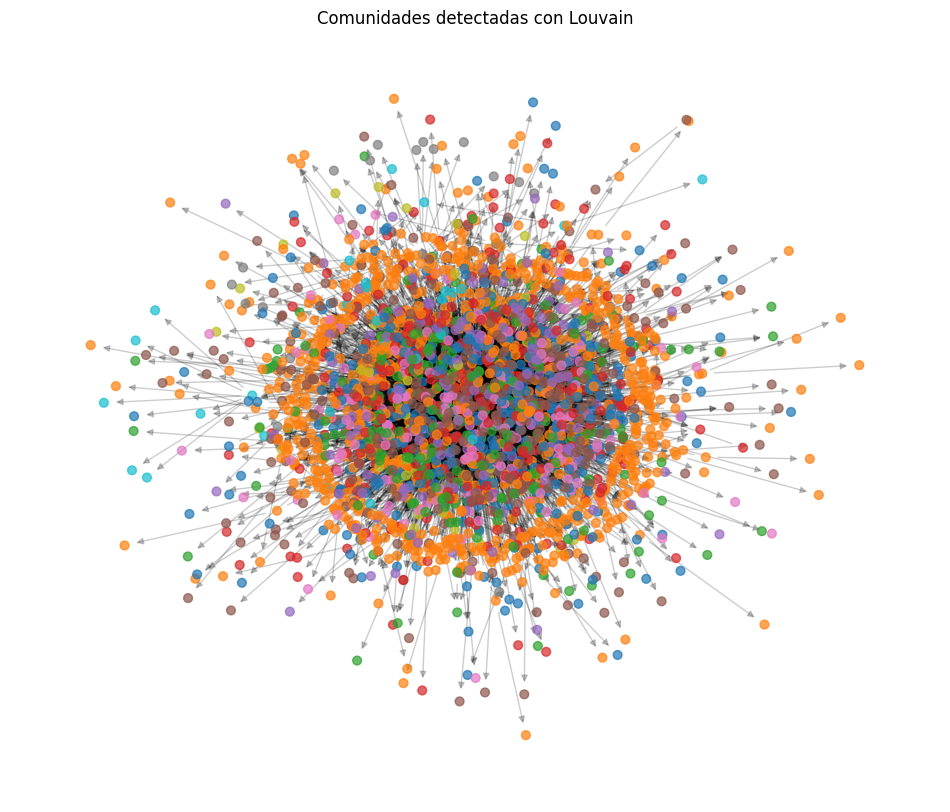

In [26]:
# Posiciones de nodos
pos = nx.spring_layout(G, k=0.3, seed=42)

plt.figure(figsize=(12,10))

# Dibujar nodos coloreados por comunidad
nx.draw_networkx_nodes(G, pos,
                       node_size=40,
                       cmap=plt.cm.tab10,
                       node_color=list(partition.values()),
                       alpha=0.7)

nx.draw_networkx_edges(G, pos, alpha=0.2)

plt.title("Comunidades detectadas con Louvain")
plt.axis("off")
plt.show()


Vemos que la comunidad más grande es la que está representada por el color anaranjado

In [40]:
from collections import defaultdict

# Agrupar nodos por comunidad
comunidades_dict = defaultdict(list)
for nodo, com in partition.items():
    comunidades_dict[com].append(nodo)

# Mostrar los primeros nodos de la comunidad más grande
for com_id, nodos in comunidades_dict.items():
    print(f"Comunidad {com_id} ({len(nodos)} nodos): {nodos[:10]}")

print(" ")
print("Top Comunidades más grandes")

# Contar tamaño de cada comunidad
comunidades = pd.Series(list(partition.values())).value_counts()
print(comunidades.head(5))

# Agregar etiquetas de comunidad al dataframe de interacciones
edges_df["source_comunidad"] = edges_df["source"].map(partition)
edges_df["target_comunidad"] = edges_df["target"].map(partition)

# Top 3 comunidades más grandes
top3 = comunidades.head(3).index.tolist()


Comunidad 0 (243 nodos): ['monymmorales', 'cc_guatemala', 'lahoragt', 'oco_motora', 'partidoune', 'mpguatemala', 'marco06ruiz', 'mariochiu2', 'radiopuntogt', 'ojguatemala']
Comunidad 1 (67 nodos): ['animaldgalaccia', 'pncdeguatemala', 'mingobguate', 'fjimenezmingob', 'guatemalagob', 'julyponce21', 'alexdel92022343', 'piero_coen', 'diariodeca', 'agn_noticias']
Comunidad 2 (57 nodos): ['diegoedeleon', 'ep_investiga', 'ldubon63', 'esta_busqueda', 'erickpinaleshou', 'darwinhk', 'oracintfaith', 'sib_guatemala', 'pavelvga', 'cc_abogado']
Comunidad 3 (230 nodos): ['amilcarmontejo', 'estaciondoblea', 'diputadojp', 'impactonoticigt', 'transito_mixco', 'dgtguate', 'pmt_villanueva', 'infotransitogt', 'pmt_sanjuansac', 'pmtsanlucassac']
Comunidad 4 (775 nodos): ['traficogt', 'barevalodeleon', 'elmerlandazuri7', 'sandratorresgua', 'bayronortega68', 'edvin111956', 'eddyarredondo23', 'efonseca2841', 'munivcanales', 'fabycalderon11']
Comunidad 5 (56 nodos): ['aztecanoticiagt', 'marinae41953239', 'cedr

La comunidad naranja es la número 4 y tiene 775 usuarios. y se ve que esta comunidad este centrada en una cuenta influyente como lo es traficogt y temas políticos, lo que muestra que muchos están alrededor de un nodo de autoridad o información.

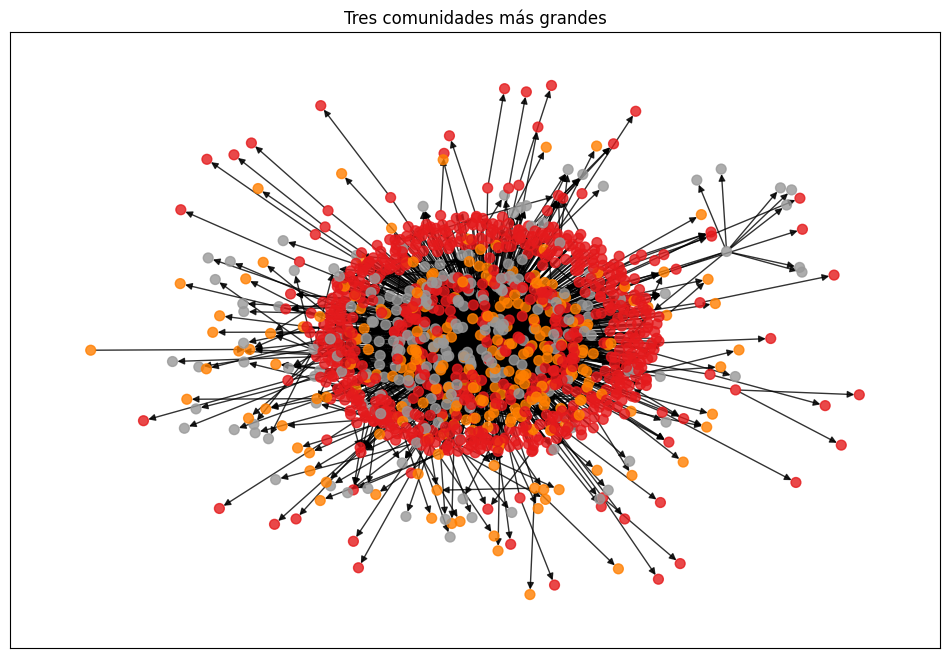

In [28]:
colors = {c: i for i, c in enumerate(top3)}

plt.figure(figsize=(12,8))
sub_nodes = [n for n, c in partition.items() if c in top3]
subG = G.subgraph(sub_nodes)

nx.draw_networkx(subG, pos=nx.spring_layout(subG, k=0.4, seed=42),
                 node_color=[colors[partition[n]] for n in subG.nodes()],
                 node_size=50, cmap=plt.cm.Set1, alpha=0.8, with_labels=False)

plt.title("Tres comunidades más grandes")
plt.show()


### 7) análisis de influencers y nodos clave

In [29]:
# 7.1) centralidades

# Centralidad de grado
grado = nx.degree_centrality(G)

# Centralidad de intermediación (betweenness)
betweenness = nx.betweenness_centrality(G)

# Centralidad de cercanía
closeness = nx.closeness_centrality(G)

# Top 10 usuarios en cada métrica
top_grado = sorted(grado.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top centralidad de grado:", top_grado)
print("\nTop centralidad de intermediación:", top_betweenness)
print("\nTop centralidad de cercanía:", top_closeness)


Top centralidad de grado: [('traficogt', 0.7120264803236485), ('barevalodeleon', 0.120264803236484), ('drgiammattei', 0.04891504229496139), ('prensacomunitar', 0.04707613093048915), ('mildred_gaitan', 0.04560500183891136), ('mmendoza_gt', 0.0419271791099669), ('batallonjalapa', 0.040823832291283564), ('mpguatemala', 0.03751379183523354), ('amilcarmontejo', 0.033835969106289075), ('lahoragt', 0.033835969106289075)]

Top centralidad de intermediación: [('traficogt', 0.018502878525493514), ('servoveritatis', 0.002180984059791276), ('madridistaguate', 0.0015080696951466543), ('jlfont001', 0.0014873915270072798), ('quorumgt', 0.0012296620327182791), ('mmendoza_gt', 0.000773828967080284), ('davidck7', 0.0007323170202004211), ('cacifguatemala', 0.0005155018378739608), ('agenciaocote', 0.0005148681193389878), ('guss_marro', 0.0005114740040538142)]

Top centralidad de cercanía: [('traficogt', 0.6954762780433983), ('barevalodeleon', 0.3848046635421788), ('drgiammattei', 0.3623340472636278), ('mp

Como se esperaba, en el top de centralidad de grado se encuentra traficogt y barevalodeleon, ya que son los más mencionados. También en intermediación aparecen los usuarios como cuentas ciudadanas y periodistas que son los puentes entre las comunidades, por último nodos bien posicionados en el centro de la red, con alta capacidad de difundir información en la centralidad de cercanía.

### 8) Detección y análisis de grupos aislados

In [30]:
# 8.1) subredes y nodos aislados

# Convertir a no dirigido para análisis de conectividad
G_und = G.to_undirected()

# Detectar componentes conexas
components = list(nx.connected_components(G_und))
print("Número de subredes detectadas:", len(components))

# Ordenarlas por tamaño
components_sorted = sorted(components, key=len, reverse=True)

# Subredes pequeñas (aisladas)
isolated_groups = [c for c in components_sorted if len(c) < 10]
print("Ejemplo de grupos aislados (usuarios):", isolated_groups[:5])


Número de subredes detectadas: 1
Ejemplo de grupos aislados (usuarios): []


### 9) Análisis de contenido y sentimiento

9.1) análisis de sentimiento
Usamos un modelo preentrenado como vaderSentiment

In [34]:
df["sentiment"] = df["clean_text"].apply(lambda x: analyzer.polarity_scores(str(x))["compound"])

# Clasificación: positivo (>0.05), negativo (<-0.05), neutral (entre -0.05 y 0.05)
def classify_sentiment(score):
    if score > 0.05: return "positivo"
    elif score < -0.05: return "negativo"
    else: return "neutral"

df["sentiment_label"] = df["sentiment"].apply(classify_sentiment)

print(df["sentiment_label"].value_counts(normalize=True))


sentiment_label
neutral     0.929158
positivo    0.052106
negativo    0.018737
Name: proportion, dtype: float64


Se observa que predomina la clase de neutral, que serían los tweets informativos sobre tráfico/accidentes. Una porción positiva que representaría felicitaciones, avisos resueltos y poca parte negativa que serían quejas, denuncias críticas, etc.

9.2) Identificación de temas
Con LDA (Latent Dirichlet Allocation) de sklearn o gensim

In [37]:
stopsp = stopwords.words("spanish")

vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words=stopsp)
X = vectorizer.fit_transform(df["clean_text"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Mostrar palabras clave por tema
for i, topic in enumerate(lda.components_):
    words = [vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-10:]]
    print(f"Tema {i+1}: {', '.join(words)}")


Tema 1: pues, golpe, hacer, mas, solo, va, gente, estan, asi, si
Tema 2: paso, mismo, van, ahi, bien, ver, entonces, ahora, mas, si
Tema 3: calle, corrupto, zona, estan, presidente, pais, trafico, pueblo, congreso, guatemala
Tema 4: ustedes, si, pacto, gobierno, gracias, guatemala, pueblo, solo, mas, corruptos
Tema 5: porras, magistrados, ley, consuelo, caso, fiscal, solo, presidente, ser, mp


Muestra que predominan mayormente temas políticos o del tráfico.

En @traficogt predominan temas de tráfico, accidentes y clima.

En @bernardoarevalodeleon predominan temas políticos, denuncias y movilizaciones.

Estos temas se alinean con las comunidades detectadas: autoridad vial, seguridad, política/activismo.

### 10) Interpretación y contexto

10.1 Contextualización de hallazgos

Influencers como nodos centrales:
@traficogt, @PNCdeGuatemala, @amilcarmontejo concentran interacciones.
Esto les da un papel clave en difusión de información y formación de agenda.

- Comunidades reflejan la estructura social:
La gran comunidad alrededor de cuentas oficiales → confianza en fuentes centralizadas.
- Comunidades medianas → colectivos ciudadanos que amplifican denuncias.
- Grupos aislados → nichos locales (vecinos, amigos, grupos pequeños).

Contenido y sentimiento:

El tono predominante es neutral-informativo, pero las críticas negativas muestran descontento social hacia autoridades y problemas estructurales (corrupción, inseguridad).

El análisis de tópicos conecta cada comunidad con temas específicos, lo que muestra cómo Twitter fragmenta la discusión pública.

En conclusión, La red de Twitter sobre tráfico y política en Guatemala refleja un sistema altamente centralizado en pocas cuentas oficiales y medios de comunicación, con comunidades ciudadanas secundarias que funcionan como amplificadores de denuncia. Aunque la mayoría de las interacciones son neutrales e informativas, los grupos negativos reflejan tensiones políticas y sociales que influyen en la percepción pública. Los influencers identificados no solo difunden información, sino que estructuran el debate y moldean la opinión pública.